Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



# AlexNet CIFAR-10 Classifier

### Network Architecture

References  
参考文献  

- [1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "[Imagenet classification with deep convolutional neural networks.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.  
- [1] Krizhevsky, Alex, Ilya Sutskever 和 Geoffrey E. Hinton. "[使用深度卷积神经网络进行Imagenet分类.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" 载于《神经信息处理系统的进展》，第1097-1105页，2012年。  

## Imports

In [2]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

#### Setting a random seed

I recommend using a function like the following one prior to using dataset loaders and initializing a model if you want to ensure the data is shuffled in the same manner if you rerun this notebook and the model gets the same initial random weights:  
如果你想确保数据在重新运行该笔记本并且模型得到相同的初始随机权重时以相同的方式被打乱，我建议在使用数据集加载器和初始化模型之前使用如下函数：


In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#### Setting cuDNN and PyTorch algorithmic behavior to deterministic

Similar to the `set_all_seeds` function above, I recommend setting the behavior of PyTorch and cuDNN to deterministic (this is particularly relevant when using GPUs).  
类似于上面的 `set_all_seeds` 函数，我建议将PyTorch和cuDNN的行为设置为确定性（这在使用GPU时特别重要）。

We can also define a function for that:  
我们也可以为此定义一个函数：

In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [5]:
##########################
### 设置
##########################

# 超参数
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# 网络结构
NUM_CLASSES = 10

# 其他
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# AdaptiveAvgPool2d 当前不支持确定性行为
#set_deterministic()  # 此函数确保在训练过程中具有确定性，但可能会与某些操作（如AdaptiveAvgPool2d）不兼容

#### Import utility functions

In [6]:
import sys

sys.path.insert(0, "..") # 包含 ../helper_evaluate.py 等文件

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

## Dataset

In [7]:
##########################
### 数据集
##########################

# 定义训练数据的预处理操作
train_transforms = transforms.Compose([transforms.Resize((70, 70)),  # 调整图片大小为70x70
                                       transforms.RandomCrop((64, 64)),  # 随机裁剪为64x64
                                       transforms.ToTensor()])  # 转换为Tensor格式

# 定义测试数据的预处理操作
test_transforms = transforms.Compose([transforms.Resize((70, 70)),  # 调整图片大小为70x70
                                      transforms.CenterCrop((64, 64)),  # 中心裁剪为64x64
                                      transforms.ToTensor()])  # 转换为Tensor格式


# 获取 CIFAR-10 数据集的加载器
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

In [8]:
# 检查验证数据集
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# 检查验证数据集
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# 检查验证数据集
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [9]:
##########################
### 模型
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [10]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=50)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3035
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0657
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.9149
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.8351
***Epoch: 001/040 | Train. Acc.: 35.951% | Loss: 1.661
***Epoch: 001/040 | Valid. Acc.: 36.680% | Loss: 1.634
Time elapsed: 0.23 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.6928
Epoch: 002/040 | Batch 0050/0175 | Loss: 1.5638
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.4921
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.5325
***Epoch: 002/040 | Train. Acc.: 43.049% | Loss: 1.497
***Epoch: 002/040 | Valid. Acc.: 44.140% | Loss: 1.483
Time elapsed: 0.46 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.5442
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.4346
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.4500
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.3207
***Epoch: 003/040 | Train. Acc.: 50.192% | Loss: 1.341
***Epoch: 003/040 | Valid. Acc.: 50.060% | Loss: 1.334
Time elapsed: 0.69 min
Epoch: 004/040 | Batch 00

## Evaluation

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


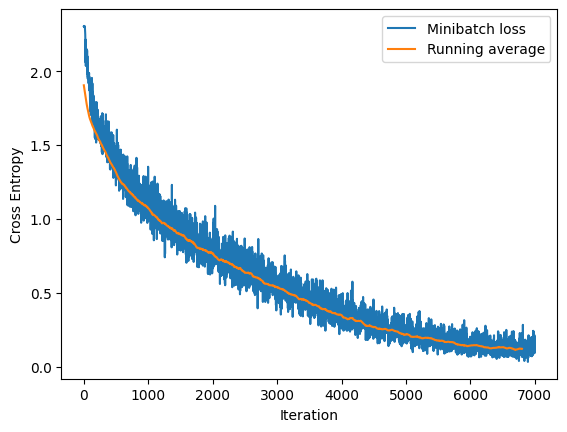

In [13]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

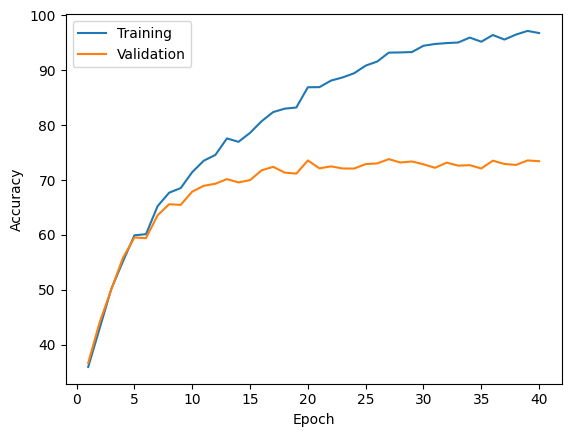

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 73.44%
Validation ACC: 73.44%
Test ACC: 73.06%


In [16]:
%watermark -iv

matplotlib : 3.10.1
torch      : 2.6.0+cu126
PIL        : 11.1.0
pandas     : 2.2.3
sys        : 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]
numpy      : 1.26.4
torchvision: 0.21.0+cu126

